# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
  * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validation
* image shape embeddings.

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments




---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set working directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/project_5_mildew_detection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/project_5_mildew_detection'

# Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set output directories

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['powdery_mildew', 'healthy']


# Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




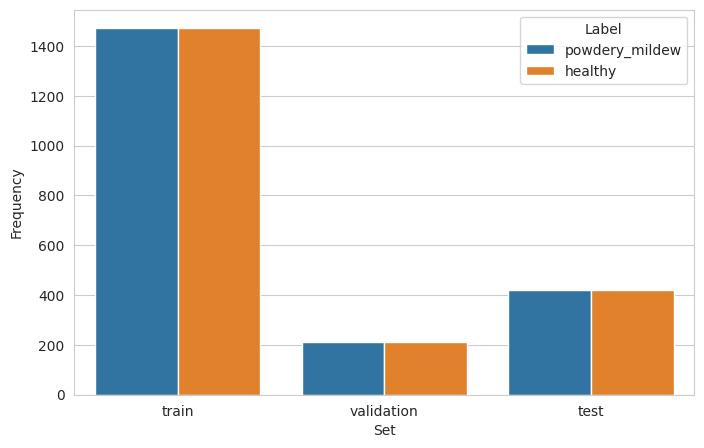

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

## ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-04 11:39:55.671203: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-04 11:39:55.726696: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-04 11:39:56.073185: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-04 11:39:56.182242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751629196.408172    3812 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751629196.58

* ## Initialize ImageDataGenerator

In [11]:
augment_image_data = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.10,
                                        height_shift_range=0.10,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        rescale=1./255
                                        )

* ## Augment training image dataset

In [12]:
sample_size = 20  # Set sample size
augmented_train_data = augment_image_data.flow_from_directory(train_path,
                                                            target_size=image_shape[:2],
                                                            color_mode='rgb',
                                                            batch_size=sample_size,
                                                            class_mode='binary',
                                                            shuffle=True
                                                            )

augmented_train_data.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ## Augment validation image dataset

In [13]:
validate_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=sample_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validate_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ## Augment test image dataset 

In [14]:
test_image_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                    target_size=image_shape[:2],
                                                                    color_mode='rgb',
                                                                    batch_size=sample_size,
                                                                    class_mode='binary',
                                                                    shuffle=False
                                                                    )

test_image_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


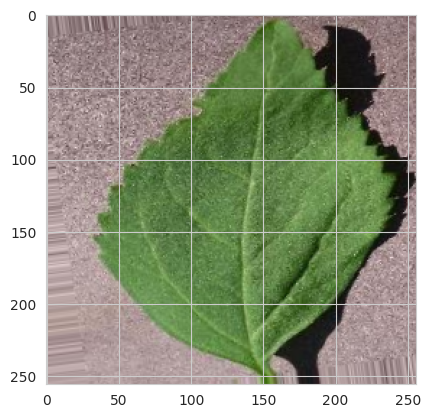

(20, 256, 256, 3)


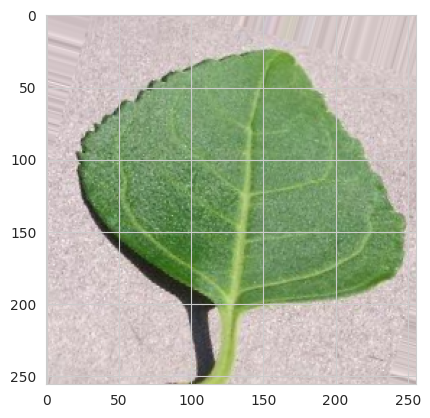

(20, 256, 256, 3)


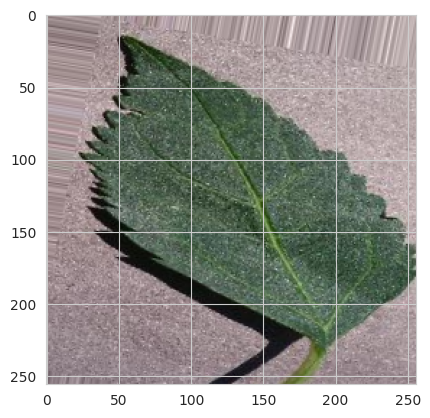

In [15]:
for _ in range(3):
    img, label = next(augmented_train_data)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(20, 256, 256, 3)


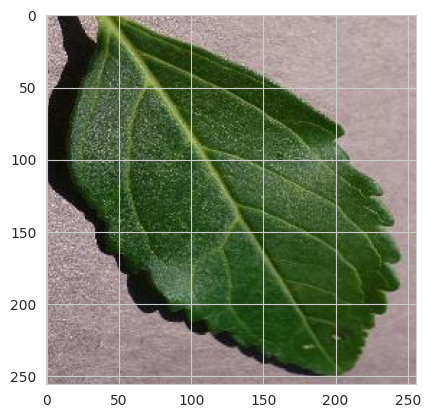

(20, 256, 256, 3)


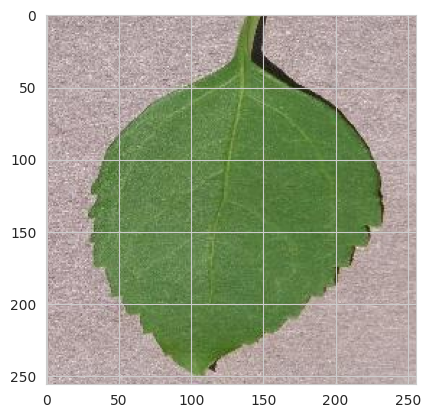

(20, 256, 256, 3)


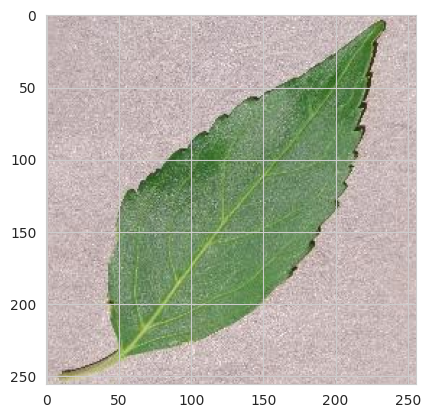

In [16]:
for _ in range(3):
    img, label = next(validate_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


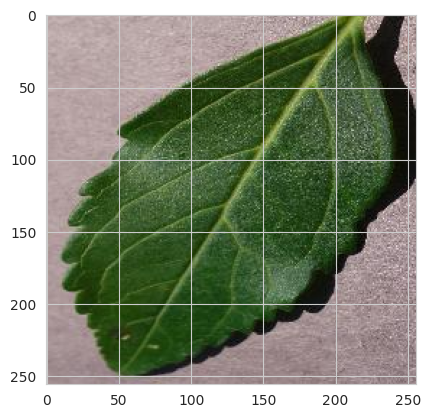

(20, 256, 256, 3)


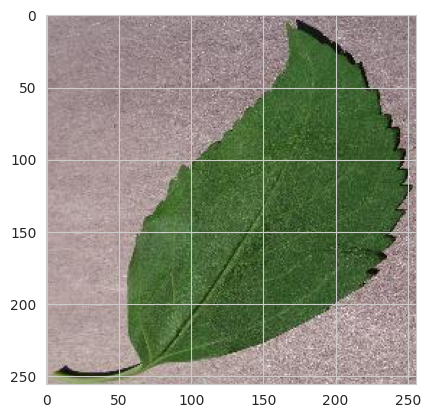

(20, 256, 256, 3)


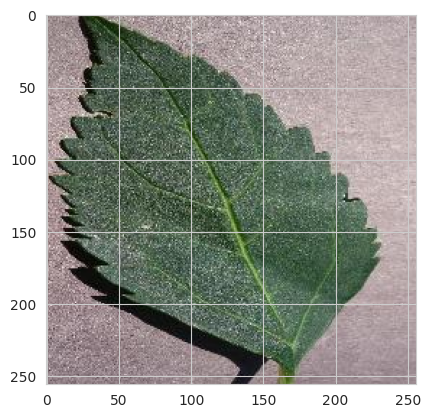

In [17]:
for _ in range(3):
    img, label = next(test_image_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [18]:
joblib.dump(value=augmented_train_data.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model

In [20]:
def cherry_leaf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

    return model

* ### Model Summary 

In [21]:
cherry_leaf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-04 11:41:18.566834: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [23]:
model = cherry_leaf_model()
model.fit(augmented_train_data,
            epochs=25,
            steps_per_epoch=len(augmented_train_data.classes) // sample_size,
            validation_data=validate_set,
            callbacks=[early_stop],
            verbose=1
            )

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 148s 993ms/step - accuracy: 0.6787 - loss: 0.6205 - val_accuracy: 0.9262 - val_loss: 0.1812
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:36 661ms/step - accuracy: 1.0000 - loss: 0.0077

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9167 - val_loss: 0.2088
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 949ms/step - accuracy: 0.9646 - loss: 0.1138 - val_accuracy: 0.9881 - val_loss: 0.0559
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 1.0000 - loss: 0.0408 - val_accuracy: 0.9833 - val_loss: 0.0623
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 192s 910ms/step - accuracy: 0.9814 - loss: 0.0549 - val_accuracy: 0.9952 - val_loss: 0.0160
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 0.9952 - val_loss: 0.0120
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 138s 938ms/step - accuracy: 0.9871 - loss: 0.0418 - val_accuracy: 0.9976 - val_loss: 0.0081
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9976 - val_loss: 0.0107
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 203s 979ms/step - accuracy: 0.9927 - loss: 0.0242 - val_acc

### Save model

In [24]:
model.save('outputs/v1/powdery_mildew_model.keras', save_format='keras')

---

# Model Performance

---

## Model learning curve

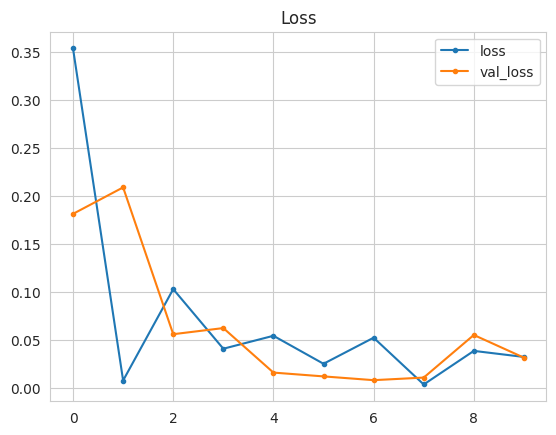

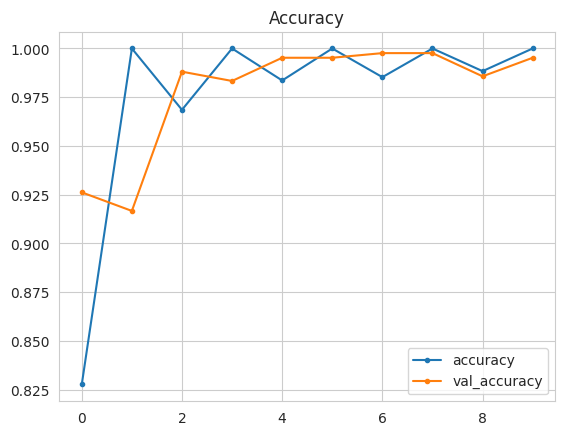

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [27]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.keras')

Evaluate model on test set

In [28]:
evaluation = model.evaluate(test_image_set)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9941 - loss: 0.0135


## Save evaluation pickle

In [29]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


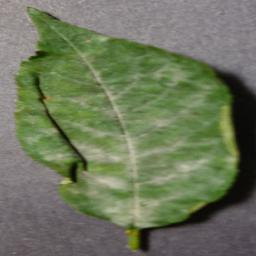

In [30]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                            target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [31]:
leaf_image = image.img_to_array(pil_image)
leaf_image = np.expand_dims(leaf_image, axis=0)/255
print(leaf_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [32]:
pred_proba = model.predict(leaf_image)[0, 0]

target_map = {v: k for k, v in augmented_train_data.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
0.99999803
powdery_mildew


---

# Push files to Repo

In [33]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
inputs/cherry_leaves_dataset/test
inputs/cherry_leaves_dataset/train

In [34]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/Modelling and Evaluating.ipynb
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	convert_model.py
	outputs/v1/powdery_mildew_model.keras

no changes added to commit (use "git add" and/or "git commit -a")


In [35]:
!git add .

In [36]:
!git commit -am " Add new plots"

[main d975e2e]  Add new plots
 5 files changed, 69 insertions(+), 72 deletions(-)
 create mode 100644 convert_model.py
 rewrite outputs/v1/model_training_acc.png (99%)
 rewrite outputs/v1/model_training_losses.png (99%)
 create mode 100644 outputs/v1/powdery_mildew_model.keras


In [41]:

!git push

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1.17 KiB | 1.17 MiB/s, done.
Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/IeuanPriede/project_5_mildew_detection
   6ca6593..6d10d87  main -> main
